In [1]:
%load_ext autoreload
%autoreload 2
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import signatory
import datetime
import warnings
import math
import itertools
import random
from sklearn.exceptions import ConvergenceWarning

from tqdm import tqdm
from copy import deepcopy
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from statsmodels.regression.linear_model import OLS

from sklearn.linear_model import ElasticNetCV, RidgeCV, LassoCV

ModuleNotFoundError: No module named 'torch'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Signature regression model

In [3]:
class Rolling_sig:
  def __init__(self, max_delta, trunc_order, C, train_start_date=pd.to_datetime('2000-01-01'),
               test_start_date=pd.to_datetime('2019-01-01'), test_end_date=pd.to_datetime('2023-12-31')):
    self.max_delta = max_delta
    self.trunc_order = trunc_order
    self.C = C
    self.train_start_date = train_start_date
    self.test_start_date = test_start_date
    self.test_end_date = test_end_date


  def split_data(self, spx, vix):
    timeline = spx.index.date
    idx_train_start_date = np.where(timeline>=self.train_start_date.date())[0][0]
    data_start_date = timeline[idx_train_start_date-self.max_delta+1]
    X_train = spx.loc[data_start_date:self.test_start_date].values
    X_test = spx.loc[self.test_start_date:test_end_date].values

    y_train = vix.loc[self.train_start_date:self.test_start_date].values
    y_test = vix.loc[self.test_start_date:self.test_end_date].values
    return X_train, X_test, y_train, y_test

  def gen_sig(self, X_train, X_test, basepoint=True, X_scaled=False):
    N_train = X_train.shape[0]
    N_test = X_test.shape[0]
    N = N_train + N_test
    nb_features = np.sum([self.C**i for i in range(1, self.trunc_order+1)])
    paths = np.hstack([X_train, X_test])

    X_train_features = []
    for i in range(N_train-self.max_delta+1):
      n_steps = self.max_delta - int(i%10)
      path_added = torch.tensor(np.array([np.arange(1, n_steps+1) / self.max_delta, 
                                          paths[i+self.max_delta-n_steps:i+self.max_delta]]).T.reshape(1, -1, 2))
      X_train_features.append(signatory.signature(path_added, depth=self.trunc_order, basepoint=basepoint).numpy())
    X_train_features = np.array(X_train_features).reshape(-1, nb_features)

    X_test_features = []
    for i in range(N_train+1, N+1):
      n_steps = self.max_delta - int(i%10)
      path_added = torch.tensor(np.array([np.arange(1, n_steps+1) / self.max_delta, paths[i-n_steps:i]]).T.reshape(1, -1, 2))
      X_test_features.append(signatory.signature(path_added, depth=self.trunc_order, basepoint=basepoint).numpy())
    X_test_features = np.array(X_test_features).reshape(-1, nb_features)
    return X_train_features, X_test_features

def dictionary_of_words(dim, trunc):
    alphabet = ""
    for i in range(dim):
        alphabet += str(i + 1)
    words = [x for t in range(1, trunc+1) for x in itertools.product(alphabet, repeat=t)]
    # words.insert(0, ("ø",))
    return words

# Simulation

In [4]:
load_from = pd.to_datetime('1990-01-01')  # Need at least 10 years prior to the first training day
train_start_date = pd.to_datetime('2000-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2023-12-31')

# Load data on SPX and VIX
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

spx_data.index = pd.to_datetime(spx_data.index.date)
vix_data.index = pd.to_datetime(vix_data.index.date)

In [5]:
spx_data.to_csv('spx_history.csv', index_label="Date")
vix_data.rename(columns={"Close": "CLOSE"}).to_csv('vix_history.csv', index_label="DATE")

In [6]:
spx = spx_data['Close'].pct_change(1)
vix = vix_data['Close'] / 100

max_delta = 250  # Number of past returns used in the computation of R_{n,t} in business days
trunc_order = 5
C = 2

sig = Rolling_sig(max_delta, trunc_order, C)
X_train, X_test, y_train, y_test = sig.split_data(spx, vix)
X_train_features, X_test_features = sig.gen_sig(X_train, X_test)
N_train = X_train_features.shape[0]

words = dictionary_of_words(2, trunc_order)
corr = pd.DataFrame(0., columns=["corr", "corr_abs"], index=words)
for i in range(X_train_features.shape[1]):
  corr.iloc[i, 0] = np.corrcoef(X_train_features[:, i], y_train)[0,1]
  corr.iloc[i, 1] = np.abs(np.corrcoef(X_train_features[:, i], y_train)[0,1])

Train score:  0.9219937404836684
Test score:  0.7145409344454465


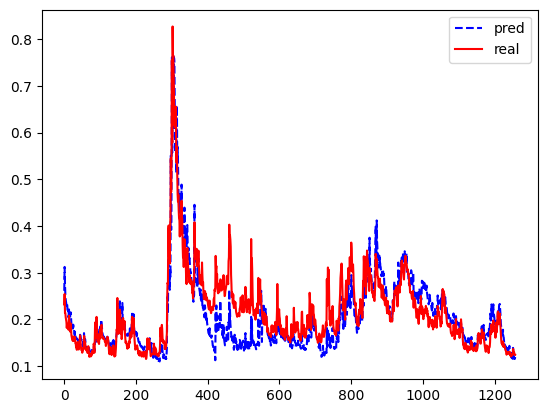

In [7]:
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

model = RidgeCV(alphas=np.linspace(10**-4, 10**-1, num=100), cv=5).fit(X_train_features_scaled, y_train)
print("Train score: ", model.score(X_train_features_scaled, y_train))
print("Test score: ", model.score(X_test_features_scaled, y_test))

y_pred = model.predict(X_test_features_scaled)
plt.plot(y_pred, "b--", label="pred")
plt.plot(y_test, "r", label="real")
plt.legend()
plt.show()

# StatSignature regression model

In [13]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append("..")
    
from signature.signature.expected_signature import expected_stationary_signature
from signature.signature.tensor_algebra import TensorAlgebra, TensorSequence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
from numpy.typing import NDArray
from numpy import float64, complex128
from typing import Union
from numba import jit

from signature.signature.tensor_sequence import TensorSequence
from signature.signature.alphabet import Alphabet
from signature.signature.stationary_signature import G_inv
from signature.signature.ode_integration import ode_stat_pece


def expected_stationary_signature_2(trunc: int, lam: int, t: float = None, n_points: int = 100) -> TensorSequence:
    """
    Computes expected stationary lambda-signature of X_t = (t, W_t). If t is not specified,
    computes stationary expected signature E^lam = E[SigX^lam]. Otherwise, computes E_t^lam = E[SigX_{0, t}^lam].

    :param trunc: truncation order of the result.
    :param lam: stationary signature parameter.
    :param t: time index of the expected signature. By default, t = inf, which corresponds to stationary signature.
    :param n_points: number of points to be used to solve an SDE on E_t^lam.

    :return: expected signature as a TensorSequence instance.
    """
    # w = 1 + 0.5 * 22
    w = TensorSequence(Alphabet(2), trunc, np.array([1, 0.5], dtype=complex128), np.array([1, 6]))

    if t is None:
        res = TensorSequence(Alphabet(2), trunc, np.ones((1, 1, 1), dtype=complex128), np.array([0]))
        v = TensorSequence(Alphabet(2), trunc, np.ones((1, 1, 1), dtype=complex128), np.array([0]))
        for _ in range(trunc):
            v.update(G_inv(v.tensor_prod(w)))
            res.update(res + v)
        return res
    else:
        t_grid = np.linspace(0, t, n_points)
        return ode_stat_pece(func=__expected_sig_ode_func, t_grid=t_grid, u=TensorSequence(w.alphabet, trunc, np.ones((1, 1, 1)), np.zeros(1)), lam=lam)

In [16]:
C = 2

ta = TensorAlgebra(dim=C)

Compiling...
Compilation finished.


In [167]:
trunc_order = 5
lam = 6.3
lam2 = 6.3

expected_ssig = expected_stationary_signature_2(trunc=trunc_order * 2, lam=lam)

def dot_l2(l1: TensorSequence, l2: TensorSequence):
    return (l1.shuffle_prod(l2) @ expected_ssig).real.squeeze()

TypeError: too many positional arguments

In [168]:
n_max = 2**(trunc_order + 1) - 1
ssig_basis = []
index_to_keep = []
for k in range(n_max):
    e_k = ta.from_array(trunc=trunc_order * 2, array=np.eye(1, n_max, k=k).reshape((-1, 1, 1)))
    print(f"Step {k}")
    ta.print(e_k)
    to_substract = e_k.zero(e_k.alphabet, e_k.trunc)
    for e in ssig_basis:
        to_substract = to_substract + e * (dot_l2(e_k, e) / dot_l2(e, e))
    e_k = e_k - to_substract
    nrm = dot_l2(e_k, e_k)
    if not np.isclose(np.abs(nrm * lam**(2 * ta.alphabet.index_to_length(np.array([k])))), 0):
        e_k = e_k
        ssig_basis.append(e_k)
        print(f"{k}-th element (norm = {nrm}):")
        index_to_keep.append(k)
    else:
        print(f"Removed {k}-th element, {nrm}:")
    print("\n")

Step 0
1.0*∅


NameError: name 'dot_l2' is not defined

In [169]:
from signature.signature.stationary_signature import stationary_signature_from_path

In [235]:
class RollingStatSig:
  def __init__(self, max_delta, trunc_order, C, lam, train_start_date=pd.to_datetime('2000-01-01'),
               test_start_date=pd.to_datetime('2019-01-01'), test_end_date=pd.to_datetime('2023-12-31')):
    self.max_delta = max_delta
    self.trunc_order = trunc_order
    self.C = C # dim of the alphabet
    self.lam = lam
    self.train_start_date = train_start_date
    self.test_start_date = test_start_date
    self.test_end_date = test_end_date


  def split_data(self, spx, vix):
    timeline = spx.index.date
    idx_train_start_date = np.where(timeline>=self.train_start_date.date())[0][0]
    data_start_date = timeline[idx_train_start_date-self.max_delta+1]
    timeline_data = spx.loc[data_start_date:self.test_end_date].index.date
    t_grid = np.array((pd.to_datetime(timeline_data) - self.train_start_date).days / 250)
    self.t_grid = t_grid
      
    idx_train_start_date = np.where(timeline>=self.train_start_date.date())[0][0]
    data_start_date = timeline[idx_train_start_date-self.max_delta+1]
    X_train = np.array([spx.loc[data_start_date:self.test_start_date].values]).T
    X_test = np.array([spx.loc[self.test_start_date:test_end_date].values]).T

    # X_train = np.array([spx.loc[data_start_date:self.test_start_date].values, vix.loc[data_start_date:self.test_start_date].values]).T
    # X_test = np.array([spx.loc[self.test_start_date:test_end_date].values, vix.loc[self.test_start_date:test_end_date].values]).T

    y_train = vix.loc[self.train_start_date:self.test_start_date].values
    y_test = vix.loc[self.test_start_date:self.test_end_date].values
    return X_train, X_test, y_train, y_test

  def gen_sig(self, X_train, X_test, basepoint=True, X_scaled=False):
    N_train = X_train.shape[0]
    N_test = X_test.shape[0]
    N = N_train + N_test
    nb_features = np.sum([self.C**i for i in range(1, self.trunc_order+1)]) * 2

    # X = np.hstack([X_train, X_test])

    X = np.vstack([X_train, X_test])
      
    # path = np.hstack([self.t_grid[:, None], X[:, None]])

    qv = np.vstack([[0], np.cumsum(np.diff(X, axis = 0)**2, axis=0)])
    print(qv)
    path = np.hstack([self.t_grid[:, None], X, qv])
    print("Path shape:", path.shape)
      
    ssig = stationary_signature_from_path(path=path, trunc=trunc_order, t_grid=self.t_grid, lam=self.lam)
    # ssig2 = stationary_signature_from_path(path=path, trunc=trunc_order, t_grid=self.t_grid, lam=lam2)

    X_features = np.zeros((ssig.array.shape[1], (ssig.array.shape[0] - 1)))
    # X_features = np.zeros((ssig.array.shape[1], len(ssig_basis) - 1))
      
    #for i, e in enumerate(ssig_basis[1:]):
    #    X_features[:, i] = (ssig @ e).real.squeeze()
    X_features[:, :nb_features] = ssig.array[1:, :, 0].T.real
    #X_features[:, nb_features//2:] = ssig2.array[1:, :, 0].T.real
    X_train_features = X_features[:N_train - self.max_delta + 1]
    X_test_features = X_features[N_train - self.max_delta + 1:]
      
    return X_train_features, X_test_features

def dictionary_of_words(dim, trunc):
    alphabet = ""
    for i in range(dim):
        alphabet += str(i + 1)
    words = [x for t in range(1, trunc+1) for x in itertools.product(alphabet, repeat=t)]
    # words.insert(0, ("ø",))
    return words

# Simulation

In [236]:
load_from = pd.to_datetime('1990-01-01')  # Need at least 10 years prior to the first training day
train_start_date = pd.to_datetime('2000-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2023-12-31')

# Load data on SPX and VIX
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

spx_data.index = pd.to_datetime(spx_data.index.date)
vix_data.index = pd.to_datetime(vix_data.index.date)

In [287]:
spx = np.log(spx_data['Close'])
# spx = spx_data['Close'].pct_change(1)
vix = vix_data['Close'] / 100

max_delta = 2000  # Number of past returns used in the computation of R_{n,t} in business days
C = 3
lam = 4.4 # 6.3
lam2 = 0.6
trunc_order = 3

sig = RollingStatSig(max_delta, trunc_order, C, lam=lam)
X_train, X_test, y_train, y_test = sig.split_data(spx, vix)
X_train_features, X_test_features = sig.gen_sig(X_train, X_test)
N_train = X_train_features.shape[0]

# X_train_features = X_train_features[:, np.array(index_to_keep)[1:] - 1]
# X_test_features = X_test_features[:, np.array(index_to_keep)[1:] - 1]

[[0.00000000e+00]
 [5.85022258e-10]
 [2.91815143e-09]
 ...
 [1.07858359e+00]
 [1.07858372e+00]
 [1.07859173e+00]]
Path shape: (8036, 3)


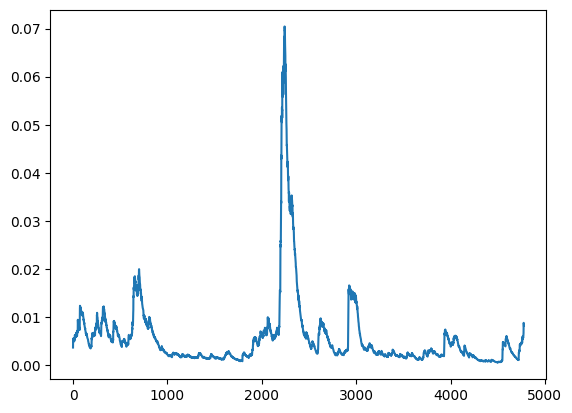

In [288]:
plt.plot(X_train_features[:, 2])

In [289]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LassoLarsIC


pipe_lasso = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic"))
pipe_lasso.fit(X_train_features, y_train)
df_lasso = pd.DataFrame(np.array([
    np.array(pd.DataFrame(X_train_features).columns.astype(int)),
    pipe_lasso['lassolarsic'].coef_
]).T,
    columns=['feature', 'weight']
)
lasso_features = list(df_lasso[df_lasso.weight != 0].feature.astype(int))
len(lasso_features)


X_train_features = X_train_features[:, lasso_features]
X_test_features = X_test_features[:, lasso_features]

words = dictionary_of_words(2, trunc_order)
corr = pd.DataFrame(0., columns=["corr", "corr_abs"], index=np.arange(X_train_features.shape[1]))
for i in range(X_train_features.shape[1]):
  rho = np.corrcoef(X_train_features[:, i], y_train)[0,1]
  if np.isnan(rho):
      rho = 0
  corr.iloc[i, 0] = rho
  corr.iloc[i, 1] = np.abs(rho)

Train score:  0.9467983531680402
Test score:  0.754098176133436


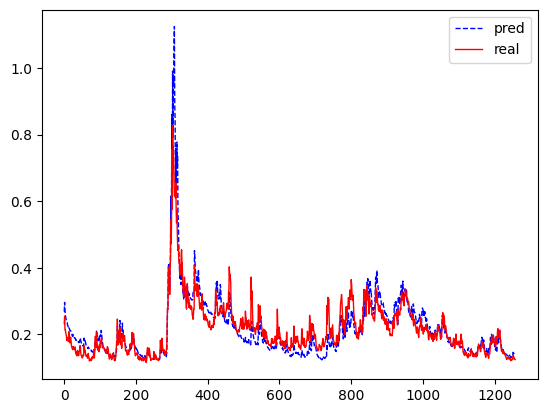

In [290]:
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

# X_train_features_scaled = X_train_features_scaled[:, np.where(corr.corr_abs >= 0.075)[0]]
# X_test_features_scaled = X_test_features_scaled[:, np.where(corr.corr_abs >= 0.075)[0]]

model = RidgeCV(alphas=np.linspace(10**-5, 10**-1, num=100), cv=5).fit(X_train_features_scaled, y_train)
print("Train score: ", model.score(X_train_features_scaled, y_train))
print("Test score: ", model.score(X_test_features_scaled, y_test))

y_pred = model.predict(X_test_features_scaled)
plt.plot(y_pred, "b--", label="pred", lw=1)
plt.plot(y_test, "r", label="real", lw=1)
plt.legend()
plt.show()

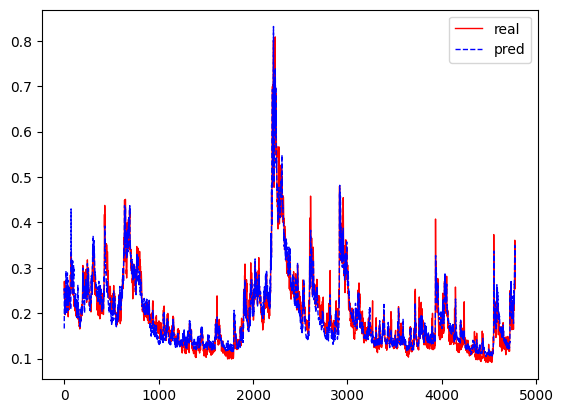

In [291]:
y_pred_train = model.predict(X_train_features_scaled)
plt.plot(y_train, "r", label="real", lw=1)
plt.plot(y_pred_train, "b--", label="pred", lw=1)
plt.legend()
plt.show()